# 健診データによる肝疾患判定 (SIGNATE 練習問題用コンペティション)

#### 【課題】
日本の医療費は、高齢化や医療の高度化を背景に年々増加し、近年は40兆円を超える規模にまで膨らんでいます。 <br>
医療費の増加を抑えるには、予防医療やリスク管理、つまり病気の発症を未然に防ぐ取り組みが重要です。 <br>
また、こうした予防的な取り組みは、個人だけに求められるものではなく、近年は企業の「健康経営」戦略として、従業員の健康作り、ひいては組織活性化につながるものとして注目されています。<br>
健康意識やヘルスリテラシの向上を目的として、比較的身近な健康診断（血液検査）のデータを活用した疾患リスク予測にチャレンジします。<br>

#### 【本コンペについて】
このコンペティションは『健康診断（血液検査）のデータを使って、肝疾患の有無を判定するモデルを作成する』という内容の練習課題です。<br>
コンペティション内では血液検査データ「disease_train.csv」「disease_test.tsv」が配布されています。<br>
既知のデータ「disease_train.csv」を用いて予測モデルを作成し、モデルによって未知のデータ「disease_test.tsv」のdisease（疾患あり:1、疾患なし:0）を判定する『分類問題』になります。<br>

※配布データの再配布は禁止されています。

#### 【データ概要】課題種別：分類　データ種別：多変量　学習データサンプル数：891　説明変数の数：10　欠損値：有り

##### 

##### １．血液検査データの読込&確認
##### ２．検査データの特徴の洗い出し　
##### ３．肝疾患リスク判定モデルの作成　
##### ４．検査データの特徴を利用したモデル改善
##### ５．テストデータによる予測

##### 

### １．血液検査データの読込&確認

まずは今回のデータ分析に使用するライブラリをimportします。 それぞれ以下の機能が提供されています。

numpy：数値計算、pandas：データ加工、matplotlib＆seaborn：グラフによる可視化、scikit-learn：機械学習モデルの提供

In [1]:
# numpy, pandas, matplotlib, seaborn, scikit-learnライブラリ
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# scikit-learnライブラリ
# データ分割
from sklearn.model_selection import train_test_split
# ロジスティック回帰モデル
from sklearn.linear_model import LogisticRegression
# 混同行列
from sklearn.metrics import confusion_matrix
# ROC曲線
from sklearn.metrics import roc_auc_score, roc_curve
# 多項式特徴量
from sklearn.preprocessing import PolynomialFeatures
# 組み込み法モデル
from sklearn.feature_selection import SelectFromModel

In [2]:
# データの表示行数を無制限に指定
pd.set_option('display.max_rows', None)

In [3]:
# 警告の非表示設定
import warnings
warnings.filterwarnings('ignore')

学習データ「disease_train.csv」を読み込みます。disease_train.csvの内容は以下の通りです。<br>
<br>
【カラム一覧】<br>
Age：年齢<br>
Gender：性別<br>
T_Bil：総ビリルビン (Total Bilirubin)<br>
D_Bil：直接ビリルビン (Direct Bilirubin)<br>
ALP：アルカリフォスファターゼ (Alkaline Phosphotase)<br>
ALT_GPT：アラニンアミノトランスフェラーゼ (Alanine Transaminase)<br>
AST_GOT：アスパラギン酸アミノトランスフェラーゼ (Aspartate Aminotransferase)<br>
TP：総タンパク (Total Protiens)<br>
Alb：アルブミン (Albumin)<br>
AG_ratio：アルブミン/グロブリン比<br>
disease：肝疾患の有無（0：無, 1：有）<br>
<br>
ここで、diseaseカラムが目的変数、それ以外のカラムが説明変数になります。<br>

In [4]:
# 学習データの読み込み
df_train = pd.read_csv('signate_data/disease/disease_train.csv')
df_train = df_train.set_index('id')
# 学習データを一部表示
df_train.head(50)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
id,,,,,,,,,,,
0,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0
5,62,Male,11.1,5.7,699.0,64.0,100.1,7.4,3.3,0.64,1
6,32,Male,12.4,6.0,514.9,48.1,92.1,6.5,2.5,0.81,1
7,37,Female,0.8,0.1,152.0,89.9,20.9,7.0,4.3,1.43,0
8,41,Male,0.9,0.2,114.0,20.9,22.9,7.0,3.1,1.04,0


In [5]:
# 学習データの行数＆列数を確認
print('学習データの行数：', df_train.shape[0])
print('学習データの列数：', df_train.shape[1])

学習データの行数： 891
学習データの列数： 11


In [6]:
# 学習データの情報を確認
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       891 non-null    int64  
 1   Gender    891 non-null    object 
 2   T_Bil     891 non-null    float64
 3   D_Bil     891 non-null    float64
 4   ALP       891 non-null    float64
 5   ALT_GPT   891 non-null    float64
 6   AST_GOT   891 non-null    float64
 7   TP        891 non-null    float64
 8   Alb       891 non-null    float64
 9   AG_ratio  887 non-null    float64
 10  disease   891 non-null    int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 83.5+ KB


In [7]:
# 学習データ内でNaNを含む行を表示
df_train[df_train.isnull().any(axis=1)]

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
id,,,,,,,,,,,
31,75,Male,8.3,4.6,386.1,30.0,25.1,5.6,1.9,NaN,1
278,29,Male,1.3,0.3,75.0,25.0,26.0,5.2,2.8,NaN,1
495,49,Male,0.8,0.3,189.1,18.2,20.1,7.3,3.8,NaN,0
648,64,Male,0.8,0.2,199.0,19.1,22.2,6.2,3.6,NaN,0


学習データのAG_ratioカラムの一部には欠損値NaNが存在するので、公式「AG_ratio=Alb/(TP-Alb)」を利用して穴埋めをします。

In [8]:
# 欠損値の補完（AG_ratioの欠損値を、Alb/(TP-Alb)の計算結果で埋める）
df_train["AG_ratio"].fillna(df_train["Alb"] / (df_train["TP"] - df_train["Alb"]), inplace=True)
# 欠損値が含まれていた行が上書きされているか確認
df_train.loc[[31,278,495,648], :]

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
id,,,,,,,,,,,
31,75,Male,8.3,4.6,386.1,30.0,25.1,5.6,1.9,0.513514,1
278,29,Male,1.3,0.3,75.0,25.0,26.0,5.2,2.8,1.166667,1
495,49,Male,0.8,0.3,189.1,18.2,20.1,7.3,3.8,1.085714,0
648,64,Male,0.8,0.2,199.0,19.1,22.2,6.2,3.6,1.384615,0


##### 

### ２．検査データの特徴の洗い出し

もう少しデータの特徴を深堀りして見ていきましょう。通常、血液検査の項目には「基準値」（正常な人の大部分が当てはまる数値の範囲）が設定されており、項目ごとに数値の大小やデータの分布は異なっています。<br>
モデルを作成する前の事前分析として、こうした項目（変数）ごとの特徴を可視化し、データを多角的に眺めることは、良いモデルを作成するための手掛かりになります。<br>
こうした一連の作業は探索的データ分析(Exploratory Data Analysis: EDA)と呼ばれます。<br>
pandasのdescribe関数で、各カラムの平均、標準偏差、最大、最小などの基本統計量を確認できます。<br>

In [9]:
df_train.describe(include='all')

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
count,891.000000,891,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,43.340067,NaN,2.807856,1.256790,268.607071,63.770146,81.336139,6.537823,3.230752,0.998036,0.483726
std,16.647096,NaN,4.922115,2.578286,226.134887,154.295258,175.539331,1.030673,0.748239,0.302349,0.500016
min,3.000000,NaN,0.400000,0.100000,63.000000,9.900000,10.100000,2.600000,0.900000,0.310000,0.000000
25%,31.000000,NaN,0.800000,0.200000,170.450000,21.900000,22.900000,5.900000,2.700000,0.810000,0.000000
50%,44.000000,NaN,1.100000,0.400000,198.000000,30.000000,35.000000,6.600000,3.200000,0.990000,0.000000
75%,57.000000,NaN,2.100000,0.900000,279.000000,51.400000,68.000000,7.300000,3.800000,1.168333,1.000000


データ全体を数量変数とカテゴリ変数に分離し、グラフで可視化してみましょう。

In [10]:
# カテゴリ変数（性別、疾患の有無）の列名をリストで指定
col_categoric = ["Gender", "disease"]
# 数量変数のデータフレームを作成
df_numeric = df_train.drop(col_categoric, axis=1)
# カテゴリ変数のデータフレームを作成
df_categoric = df_train[col_categoric]

0    460
1    431
Name: disease, dtype: int64


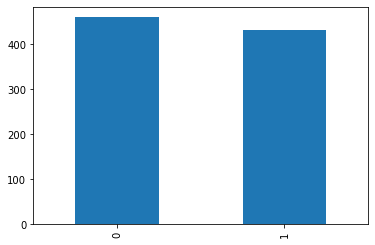

In [11]:
# disease列のカテゴリ（疾患なし:0 疾患あり:1）の個数を調べる
counts_disease = df_categoric["disease"].value_counts()
print(counts_disease)
# 棒グラフによる可視化
counts_disease.plot(kind='bar')
plt.show()

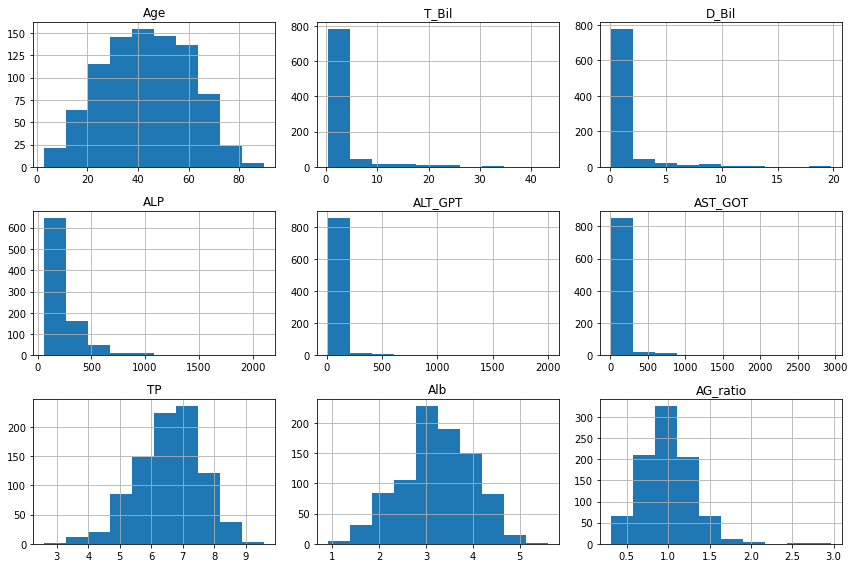

In [12]:
#数量変数のヒストグラムを表示(※figsizeオプションはグラフのサイズを指定）
df_numeric.hist(figsize=(12, 8))
# グラフのラベルが重ならないようにレイアウトを自動調整
plt.tight_layout()
plt.show()

上の様に、カテゴリ変数の場合は棒グラフで、数量変数の場合はヒストグラム（度数分布）で可視化するのが通例です。
先ほど分離した数量変数のデータフレームdf_numericと、カテゴリ変数のデータフレームdf_categoricを、再度結合することもできます。

In [13]:
# df_categoric内の"disease"列と、df_numericの列を横結合する
df_tmp = pd.concat([df_categoric["disease"], df_numeric], axis=1)
df_tmp.head()

,disease,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
id,,,,,,,,,,
0,1,60,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01
1,0,28,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36
2,1,60,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96
3,0,20,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31
4,0,44,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04


結合したdf_tmpを用いて、disease別(疾患のあり・なし)でAgeデータの抽出を行い、それぞれのヒストグラムを重ねて表示してみます。<br>
青色がdisease=0(疾患なし)、オレンジ色がdisease=1(疾患あり)に対応するAgeのヒストグラムです。<br>
目的変数のクラスごとに分布を見てみると、疾患ありの方が分布がやや右よりになっており、50歳前後でピークが来ていることが分かります。

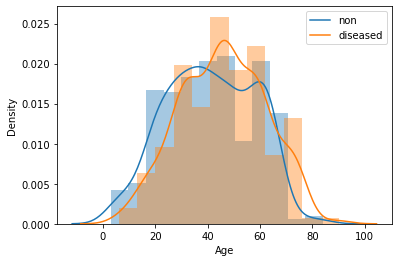

In [14]:
# diseaseの値に応じた"Age"データの抽出
df_Age_non = df_tmp.query('disease == 0')['Age']
df_Age_diseased = df_tmp.query('disease == 1')['Age']
# 2つのデータフレームのヒストグラムを同時に表示
sns.distplot(df_Age_non)
sns.distplot(df_Age_diseased)
# 凡例の表示
plt.legend(labels=["non", "diseased"], loc='upper right')
plt.show()

同様にT_Bilのヒストグラム(下図)も表示してみると、疾患なしの人(青色)のT_Bil値はだいたい0.5~1.0に集中しており1.0以上をとる人は少なく、疾患ありの人(オレンジ色)と分けるには1.0を境界とすることができると判断できます。<br>
他の検査項目についても、同じような正常値と異常値との「区切り」があるのではないかと推測されます。<br>

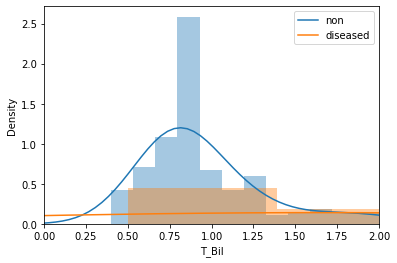

In [15]:
#"T_Bil"データを疾患なしと疾患ありの場合に分ける
df_T_Bil_non = df_tmp.query("disease==0")["T_Bil"]
df_T_Bil_diseased = df_tmp.query("disease==1")["T_Bil"]
#グラフの表示
sns.distplot(df_T_Bil_non)
sns.distplot(df_T_Bil_diseased)
plt.legend(labels = ["non", "diseased"], loc = 'upper right')
plt.xlim(0.0, 2.0)
plt.show()

他の変数もまとめてプロットしてみましょう。

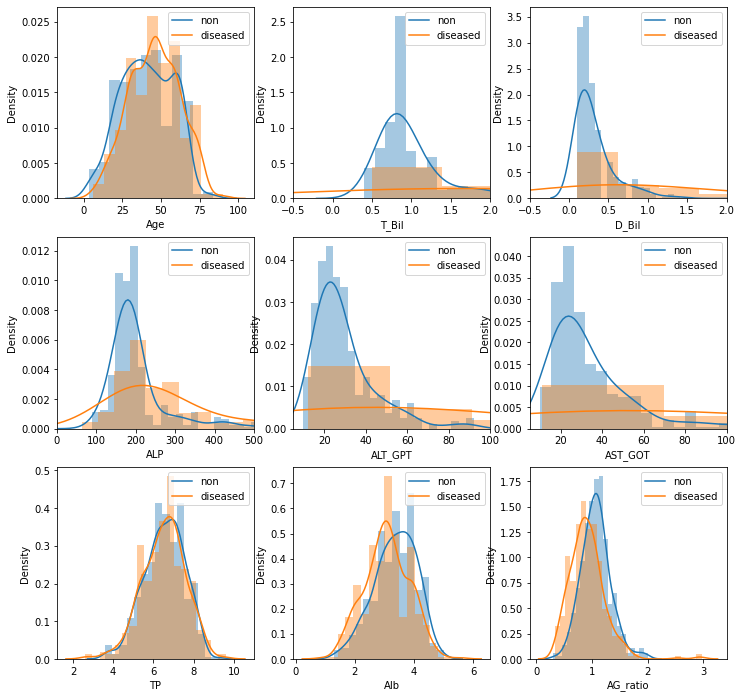

In [16]:
#グラフの表示
plt.figure(figsize=(12, 12))

for ncol, colname in enumerate(df_numeric.columns):
    # 複数のプロットをまとめる
    plt.subplot(3, 3, ncol+1)
    # 2つのデータフレームのヒストグラムを同時に表示
    sns.distplot(df_tmp.query("disease == 0")[colname])
    sns.distplot(df_tmp.query("disease == 1")[colname])
    # 凡例の表示
    plt.legend(labels=["non", "diseased"], loc='upper right')
    # 特定のグラフの大きさを変更
    if ncol in [1, 2]:
        plt.xlim(-0.5, 2.0)
    if ncol == 3:
        plt.xlim(0.0, 500.0)
    if ncol in [4, 5]:
        plt.xlim(5.0, 100.0)
plt.show()

D_Bil, ALP, ALT_GPT, AST_GOTは、先ほどのT_Bilと同様に、ある基準値よりも大きい場合に異常と判断する、という仮説が立てられそうです。<br>
Alb, AG_ratioでは、疾患ありの分布が左に寄っており、逆にある基準値よりも小さい場合に異常と判断する、という仮説が立てられそうです。<br>
TPについては、疾患ありと疾患なしの分布がほぼ丁度重なっており、明確な区切りを付けるのが難しそうです。<br>

また、変数間の関係性を見る1つの方法として『相関係数』があります。相関関係とは、2種類の変数の一方が変化した時、もう一方の変数もそれに応じて変化するような関係を指します。

In [17]:
# 各変数の相関係数
corr_matrix = df_train.corr()
corr_matrix

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
Age,1.000000,0.023838,0.022956,0.043923,-0.068371,-0.043663,-0.211715,-0.261470,-0.129721,0.144898
T_Bil,0.023838,1.000000,0.992112,0.256488,0.256965,0.355203,-0.014836,-0.230144,-0.255273,0.373955
D_Bil,0.022956,0.992112,1.000000,0.254928,0.236076,0.328497,-0.014602,-0.224510,-0.246936,0.366597
ALP,0.043923,0.256488,0.254928,1.000000,0.096297,0.116894,-0.023761,-0.154299,-0.192997,0.274803
ALT_GPT,-0.068371,0.256965,0.236076,0.096297,1.000000,0.866955,-0.005689,-0.010086,-0.003419,0.218902
AST_GOT,-0.043663,0.355203,0.328497,0.116894,0.866955,1.000000,-0.007298,-0.068083,-0.063965,0.259385
TP,-0.211715,-0.014836,-0.014602,-0.023761,-0.005689,-0.007298,1.000000,0.782394,0.154863,-0.016355
Alb,-0.261470,-0.230144,-0.224510,-0.154299,-0.010086,-0.068083,0.782394,1.000000,0.642402,-0.187262
AG_ratio,-0.129721,-0.255273,-0.246936,-0.192997,-0.003419,-0.063965,0.154863,0.642402,1.000000,-0.253613
disease,0.144898,0.373955,0.366597,0.274803,0.218902,0.259385,-0.016355,-0.187262,-0.253613,1.000000


上の結果をヒートマップで可視化してみましょう。ヒートマップを使うと各変数間の相関の強さが一目瞭然となります。

<AxesSubplot:>

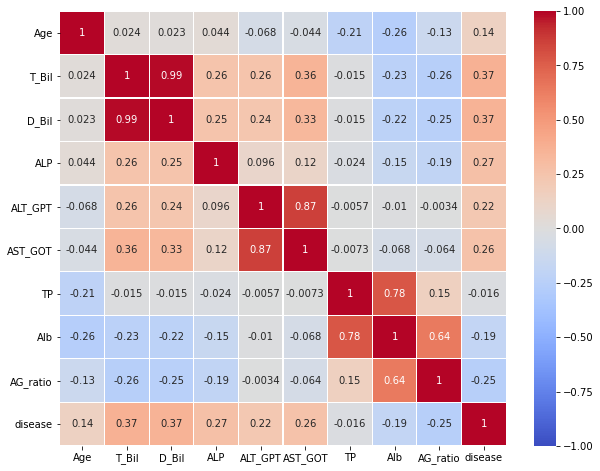

In [18]:
# 相関係数の結果をヒートマップで表示
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)

正の相関が強い(0.7～1.0)変数の組合せとして、「TPとAlb」「AlbとAG_ratio」が存在することが分かります。<br>
AG_ratio、Alb、TPの間には公式「AG_ratio=Alb/(TP-Alb)」が成り立つので、お互いの値が影響を及ぼしていると考えられ、相関係数が高いのも納得できる結果であると言えます。

#### 

### ３．肝疾患リスク判定モデルの作成

今回は健康診断の受診者の属性情報（性別、年齢）とその血液検査の結果を入力として、その人に疾患リスクが「有るか無いか」の2択で判定結果を出力するモデルを作成します。

データには質的データ（カテゴリとして測定）と量的データ（数量として測定）の2種類があります。<br>
機械学習モデルに今回扱う質的データを投入する際には、カテゴリの変数に対する『ダミー化』という前処理が必要です。<br>
ダミー化とは、例えばGender(性別)カラムでのMaleとFemaleという2種類の質的データにおいてMaleを「1」、Femaleを「0」といった数値に置き換える処理を指します。

In [19]:
# Maleが1、Femaleが0になるようにGender列をダミー化(ラムダ式を使用)
df_train['Gender'] = df_train['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [20]:
# ダミー化後の結果を表示
df_train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
id,,,,,,,,,,,
0,60,1,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,28,0,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,60,1,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,20,1,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,44,0,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0


また、学習用データフレーム「df_train」を説明変数と目的変数のデータフレームに分け、さらにモデルの学習用データと、モデルの予測精度を見るための評価用データに分割します。

In [21]:
# 説明変数のデータフレーム
X_data = df_train.drop(['disease'], axis=1)
# 目的変数のデータフレーム
y_data = df_train['disease']
# 学習用データと評価用データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

今回の分析では2値分類（0か1かの予測）でよく使用される『ロジスティック回帰モデル』という線形モデルを使用します。<br>
ロジスティック回帰とは、0と1のどちらに分類されるかを確率的に予測する手法です。(詳細な説明は省略)<br>
今回の場合、ある説明変数を与えた時に目的変数が1に分類される確率を予測していることになります。<br>

In [22]:
# ロジスティック回帰を用いたモデルの学習
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

学習させたモデルに対して評価用データを与えて疾患の有無を予測してみましょう。<br>
疾患なし:0 疾患あり:1 として、2値判定した結果が返されます。<br>

In [23]:
# 評価用データを用いて予測(2値判定の閾値は0.5)
y_pred = model.predict(X_valid)
print("y_predの結果（2値判定の結果）: ", y_pred, "\n")
# 予測結果について
print("y_predのサイズ = 評価用データのサイズ = ", y_pred.shape[0])
print("疾患あり(1)と判定された数:", sum(y_pred))

y_predの結果（2値判定の結果）:  [0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1
 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0
 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0
 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0
 1 0 0 0 1 1 1 0 0] 

y_predのサイズ = 評価用データのサイズ =  268
疾患あり(1)と判定された数: 99


判定確率の算出をすると、以下の様な0から1までの数値が表示されます。<br>
ロジスティック回帰モデルは疾患ありと判定する「確率」をまず算出し、その確率を元に0と1のどちらに属するかを判定しています。<br>
デフォルトでは、疾患の有無を判断する基準値である『閾値』の0.5 (=50%)を超える場合には1、そうでない場合には0と判定されることになります。<br>

In [24]:
# 予測（判定確率の算出）
# 疾患あり(=１)となる確率
y_pred_prob = model.predict_proba(X_valid)[:, 1]
y_pred_prob[:20]

array([0.20277925, 0.19553997, 0.20246442, 0.99956535, 0.25245297,
       0.29974963, 0.40092655, 0.4818264 , 0.75726328, 0.27276493,
       0.33945229, 1.        , 0.70570243, 0.65345307, 0.26297876,
       0.16171462, 0.228437  , 0.59722069, 0.50742792, 0.99236613])

この予測結果を可視化するために便利な『混同行列』という行列があります。<br>
混同行列とは、予測結果と実際の値（正解となるデータ）を比べて、正しく判別できた数と誤って判別してしまった数とを見やすくした行列のことです。<br>

In [25]:
# 混同行列の作成
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)
# 混同行列をデータフレーム化
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["actual_Positive", "actual_Negative"], columns=["predict_Positive", "predict_Negative"])
df_cm

,predict_Positive,predict_Negative
actual_Positive,84,53
actual_Negative,15,116


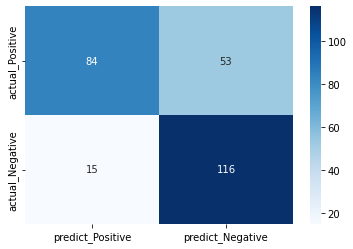

In [26]:
# heatmapによる混同行列の可視化
sns.heatmap(df_cm, annot=True, fmt="2g", cmap='Blues')
plt.yticks(va='center')
plt.show()

（actual_Positive：実際は「疾患あり」、actual_Negative：実際は「疾患なし」、predict_Positive：「疾患あり」と予測、predict_Negative：「疾患なし」と予測）<br>
上の表では、左上の値をTrue Positive (TP：真陽性)、左下の値をFalse Positive (FP：偽陽性)、右上の値をFalse Ngative (FN：偽陰性)、右下の値をTrue Negative (TN：真陰性)と呼びます。<br>
つまり評価用データのサイズ=268に対し、84(TP)+116(TN)=200だけ予測が正しいことを意味しています。<br>

<img src="confusion_matrix_copy.png">

次に、予測結果の『ROC曲線』を描画します。<br>
ROC曲線とは、二値分類問題で混同行列を利用して精度を評価するための可視化手法です。<br>
この曲線は、閾値（陽性or陰性を判断する基準値）を変化させるごとに算出される『真陽性率（True Positive Rage: TPR）』と『偽陽性率（False Positive Rate: FPR）』の各点を結んだものです。<br>
真陽性率と偽陽性率は、以下のように定義されます。<br>
<br>
・真陽性率（実際に陽性であるもののうち、正しく陽性であると判定できた割合） : $TPR = \frac{TP}{TP+FN}$<br>
・偽陽性率（実際に陰性であるもののうち、間違って陽性であると判定してしまった割合） : $FPR = \frac{FP}{FP+TN}$<br>

下のグラフでは、縦軸がTPR、横軸がFPRに対するROC曲線（青い曲線）が描画されています。<br>
ROC曲線の下の領域面積（ROC曲線とx軸と第ニy軸で囲まれた部分）をAUCと呼び、一般的にAUCが１に近づくほど良いモデルであると言えます。<br>
黄色点線の様に、AUCが0.5のときは陽性か陰性かをランダムで判定していることになり、モデルの精度が最も悪い状態であることを意味します。<br>
閾値の調整によってモデルの性能がどの様に変化するのかを、ROC曲線から視覚的に理解することができます。<br>
今回はこのAUCを評価指標として、作成したモデルを評価していきます。<br>

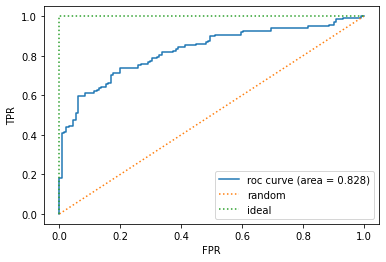

AUC: 0.8280492561430879


In [27]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_valid, y_score=y_pred_prob)
# ROC曲線の要素（偽陽性率、真陽性率、閾値）の算出
fpr, tpr, thresholds = roc_curve(y_true=y_valid, y_score=y_pred_prob)
# ROC曲線の描画
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc_score)
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print('AUC:', auc_score)

### 

### ４．検査データの特徴を利用したモデル改善

さらにモデルの精度を高めるための工夫として、以下2つの特徴量を生成する方法があります。

#### ① ビニング

ビニング(binning)とは、数値変数を「ビン」と呼ばれる特定の区間に分割し、あえてカテゴリ変数として扱う方法です。<br>
ビニングを行うことで線形モデルの柔軟性を高め、判定精度を向上させる事ができる場合があります。<br>
下の例では、T_Bilの値がどの区間に属するかでカテゴリ変数を新たに生成し、ダミー化することによって特徴量(T_Bil_0, T_Bil_1, T_Bil_2)を生成&追加しています。<br>

In [28]:
# 境界値を指定したbinの分割
bins_T_Bil = [0, 0.5, 1.0, 100]
# T_Bil列を分割し、0始まりの連番でラベル化した結果を、X_cutに格納する
X_cut, bin_indice = pd.cut(X_data["T_Bil"], bins=bins_T_Bil, retbins=True, labels=False)
# bin分割した結果をダミー変数化 (prefix=X_Cut.nameは、列名の接頭語を指定している)
X_dummies = pd.get_dummies(X_cut, prefix=X_cut.name)
# 元の説明変数のデータフレーム(X)と、ダミー変数化の結果(X_dummies)を横連結
X_binned = pd.concat([X_data, X_dummies], axis=1)
# 結果の確認
X_binned.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,T_Bil_0,T_Bil_1,T_Bil_2
id,,,,,,,,,,,,,
0,60,1,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,0,0,1
1,28,0,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0,1,0
2,60,1,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,0,0,1
3,20,1,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0,1,0
4,44,0,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0,1,0


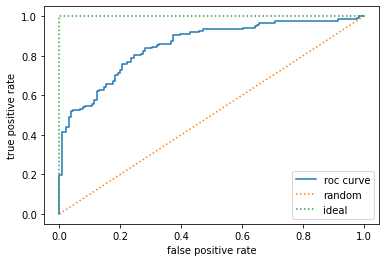

AUC: 0.853123084638101


In [29]:
# 学習用・評価用データの分割（元の説明変数Xの代わりに、bin分割したX_binnedを使う）
X_train, X_valid, y_train, y_valid = train_test_split(X_binned, y_data, test_size=0.3, random_state=0)
# モデルの学習・予測
binned_model = LogisticRegression()
binned_model.fit(X_train, y_train)
y_pred = binned_model.predict_proba(X_valid)[:, 1]
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_valid, y_score=y_pred)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_valid, y_score=y_pred)
print("AUC:", auc_score)

ビニングの実行前の結果と比べると、AUCの値がわずかに改善しました。

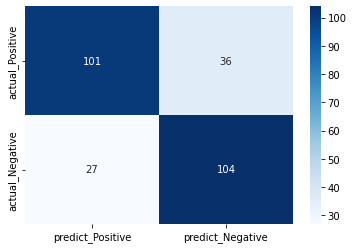

In [30]:
# 混同行列の作成
y_pred = binned_model.predict(X_valid)
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)
# 混同行列をデータフレーム化
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["actual_Positive", "actual_Negative"], columns=["predict_Positive", "predict_Negative"])
df_cm
# heatmapによる混同行列の可視化
sns.heatmap(df_cm, annot=True, fmt="2g", cmap='Blues')
plt.yticks(va='center')
plt.show()

#### ② 多項式特徴量、交互作用特徴量

『多項式特徴量』とは、各特徴量に対してある累乗を特徴量として拡張したものであり、<br>
『交互作用特徴量』とは、各特徴量の交互作用(積)を特徴量として拡張したものです。<br>
例えば、3つの特徴量を${X,Y,Z}$とすると、2次までの多項式特徴量と交互作用特徴量は${X,Y,Z,X^2,Y^2,Z^2,XY,XZ,YZ}$で表示されます。<br>

今回は元の説明変数のデータセットからGenderカラムを除き、2次までの特徴量を生成します。<br>
また、不要なものを除外して重要な特徴量を選択してくれる、組み込み法（モデルベース特徴量選択）という手法を使います。<br>
機械学習モデルの学習と特徴量選択を同時に行う方法で、ターゲットの分類に各特徴量がどれくらい寄与しているかの重要度を算出します。<br>

In [31]:
# Gender列を除外（数量変数のデータに絞る）
X_target = X_data.drop(["Gender"], axis=1)
# 多項式・交互作用特徴量の生成
polynomial = PolynomialFeatures(degree=2, include_bias=False)
polynomial_arr = polynomial.fit_transform(X_target)
X_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x) for x in range(polynomial_arr.shape[1])])


# 組み込み法のモデル、閾値の指定
fs_model = LogisticRegression(penalty='l1', random_state=0, solver='liblinear')
fs_threshold = "mean"
# 組み込み法モデルの初期化
selector = SelectFromModel(fs_model, threshold=fs_threshold)
# 特徴量選択の実行
selector.fit(X_polynomial, y_data)
mask = selector.get_support()
print(mask)
# 選択された特徴量だけのサンプル取得
X_polynomial_masked = X_polynomial.loc[:, mask]
X_polynomial_masked.head()

[False  True  True False False False  True  True  True False False False
 False False False False False False False False False False False  True
  True  True False False False False  True  True  True False False False
 False False False False False False False False False False False False
 False False  True False False  True]


,poly1,poly2,poly6,poly7,poly8,poly23,poly24,poly25,poly30,poly31,poly32,poly50,poly53
0,2.9,1.3,5.5,2.9,1.01,15.95,8.41,2.929,7.15,3.77,1.313,5.555,1.0201
1,0.7,0.1,6.4,3.7,1.36,4.48,2.59,0.952,0.64,0.37,0.136,8.704,1.8496
2,23.1,12.5,6.8,3.3,0.96,157.08,76.23,22.176,85.00,41.25,12.000,6.528,0.9216
3,1.0,0.5,7.0,3.8,1.31,7.00,3.80,1.310,3.50,1.90,0.655,9.170,1.7161
4,0.6,0.3,4.5,2.1,1.04,2.70,1.26,0.624,1.35,0.63,0.312,4.680,1.0816


In [32]:
X_polynomial_masked.shape

(891, 13)

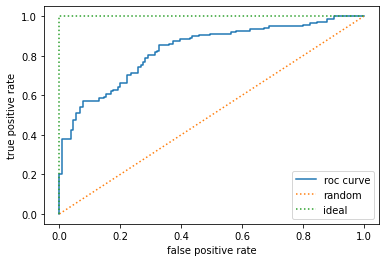

AUC: 0.8293308073772776


In [33]:
# 学習用・評価用データの分割（元の説明変数Xの代わりに、特徴量選択後のX_polynomial_maskedを使う）
X_train, X_valid, y_train, y_valid = train_test_split(X_polynomial_masked, y_data, test_size=0.3, random_state=0)
# モデルの学習・予測
polynomial_model = LogisticRegression()
polynomial_model.fit(X_train, y_train)
y_pred = polynomial_model.predict_proba(X_valid)[:, 1]
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_valid, y_score=y_pred)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_valid, y_score=y_pred)
print("AUC:", auc_score)

この手法ではモデル改善は見られませんでした。

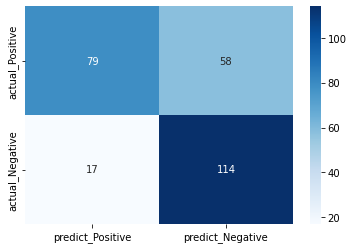

In [34]:
# 混同行列の作成
y_pred = polynomial_model.predict(X_valid)
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)
# 混同行列をデータフレーム化
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["actual_Positive", "actual_Negative"], columns=["predict_Positive", "predict_Negative"])
df_cm
# heatmapによる混同行列の可視化
sns.heatmap(df_cm, annot=True, fmt="2g", cmap='Blues')
plt.yticks(va='center')
plt.show()

### 

### ５．テストデータによる予測

テストデータ「disease_test.csv」はdiseaseが含まれていない未知のデータです。先ほどの特徴量作成の手法である「ビニング」のみで改善したモデルを用いて判定します。

In [35]:
# テストデータの読み込み
df_test = pd.read_csv('signate_data/disease/disease_test.csv')
df_test = df_test.set_index('id')
# テストデータを一部表示
df_test.head(30)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
id,,,,,,,,,,
891,65,Female,0.7,0.2,162.0,24.0,20.0,6.4,3.3,0.93
892,46,Male,1.2,0.3,265.1,40.0,28.0,7.9,3.8,0.94
893,26,Male,0.7,0.1,243.1,21.1,22.9,5.3,2.2,0.60
894,38,Male,3.5,1.7,253.0,80.0,406.0,6.8,3.7,1.33
895,46,Female,0.7,0.2,236.0,10.1,13.0,6.8,3.0,0.74
896,50,Male,2.7,1.0,610.0,17.0,28.0,7.1,2.6,0.59
897,43,Male,0.8,0.1,169.8,22.0,18.0,6.4,3.3,0.93
898,33,Male,0.8,0.3,187.2,22.9,43.0,7.3,3.1,0.75
899,49,Male,1.1,0.3,208.0,29.8,25.0,5.9,2.8,0.92


In [36]:
# テストデータの行数＆列数を確認
print('テストデータの行数：', df_test.shape[0])
print('テストデータの列数：', df_test.shape[1])

テストデータの行数： 382
テストデータの列数： 10


In [37]:
# テストデータの情報を確認
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 891 to 1272
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       382 non-null    int64  
 1   Gender    382 non-null    object 
 2   T_Bil     382 non-null    float64
 3   D_Bil     382 non-null    float64
 4   ALP       382 non-null    float64
 5   ALT_GPT   382 non-null    float64
 6   AST_GOT   382 non-null    float64
 7   TP        382 non-null    float64
 8   Alb       382 non-null    float64
 9   AG_ratio  382 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 32.8+ KB


In [38]:
# Maleが1、Femaleが0になるようにGender列をダミー化
df_test["Gender"] = df_test['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [39]:
# 境界値を指定したbinの分割
bins_T_Bil = [0, 0.5, 1.0, 100]
# T_Bil列を分割し、0始まりの連番でラベル化した結果を、X_cutに格納する
X_cut, bin_indice = pd.cut(df_test["T_Bil"], bins=bins_T_Bil, retbins=True, labels=False)
# bin分割した結果をダミー変数化 (prefix=X_Cut.nameは、列名の接頭語を指定している)
X_dummies = pd.get_dummies(X_cut, prefix=X_cut.name)
# 元の説明変数のデータフレーム(X)と、ダミー変数化の結果(X_dummies)を横連結
X_binned_test = pd.concat([df_test, X_dummies], axis=1)
X_test_data = X_binned_test

In [40]:
# 予測値の算出
y_pred_test = binned_model.predict(X_test_data)
print('y_pred_testの結果（2値判定の結果）: ', y_pred_test, '\n')
# 予測結果について
print('y_pred_testのサイズ = テストデータのサイズ = ', y_pred_test.shape[0])
print('疾患あり(1)と判定された数: ', sum(y_pred_test))

y_pred_testの結果（2値判定の結果）:  [0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1
 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0
 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0
 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0
 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0
 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0
 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1
 1 1 0 0 0 1 0 0 0 0 0 0] 

y_pred_testのサイズ = テストデータのサイズ =  382
疾患あり(1)と判定された数:  159


In [41]:
# 予測結果をDataFrame型でまとめ、提出用のCSVファイルを作成
submission = pd.DataFrame({'id': X_test_data.index, 'disease': y_pred_test})
submission.to_csv('signate_result/disease_competition_predicted.csv', header=False, index=False)

In [42]:
# 予測結果を表示
submission.head(50)

,id,disease
0,891,0
1,892,1
2,893,0
3,894,1
4,895,0
5,896,1
6,897,0
7,898,0
8,899,1
9,900,0


出力したCSVファイルをコンペティションにて投稿して完了です。

最終投稿日時：2021-03-20 22:30:13 <br>
最終評価：0.7912360<br>
最終順位：271位 / 377人投稿 <br>